#Demo of EKF vs UKF vs GHKF

This demonstrates the sigma point methods' capacity to approximate the target distribution that results from a non-linear transformation with greater accuracy than the EKF. This is because the EKF approximates the distribution locally at the mean. Furthermore, while the UKF is limited to $2n+1$ sigma points, the GHKF can be tuned to arbitrary accuracy as it uses $p^n$ sigma points where $p$ is the order of the Gauss-Hermite approximation that the user can set as a hyperparameter.

Example adapted from Figures 5.3, 5.4, 5.5, and 6.1 of Simo Särkkä (2013), “Bayesian Filtering and Smoothing."

Simo Särkkä (2013), “Bayesian Filtering and Smoothing,” Cambridge University Press. Available: https://users.aalto.fi/~ssarkka/pub/cup_book_online_20131111.pdf

Demo by Peter G. Chang ([@petergchang](https://github.com/petergchang))

##0. Imports

In [1]:
# Silence WARNING:root:The use of `check_types` is deprecated and does not have any effect.
# https://github.com/tensorflow/probability/issues/1523
import logging

logger = logging.getLogger()


class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()


logger.addFilter(CheckTypesFilter())

In [2]:
# https://github.com/probml/probml-utils/blob/main/probml_utils/plotting.py\n",
try:
    import probml_utils as pml
except ModuleNotFoundError:
    print("installing probml_utils")
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml

In [3]:
try:
    from ssm_jax.plotting import plot_ellipse
except ModuleNotFoundError:
    print("installing ssm_jax")
    %pip install -qq git+https://github.com/probml/ssm-jax.git
    from ssm_jax.plotting import plot_ellipse

In [4]:
try:
    from probml_utils import savefig, latexify
except ModuleNotFoundError:
    print("installing probml-utils")
    %pip install -qq git+https://github.com/probml/probml-utils.git
    from probml_utils import savefig, latexify

latexify(width_scale_factor=2, fig_height=1.5)  # for book

/opt/anaconda3/lib/python3.8/site-packages/probml_utils/plotting.py:25: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


In [6]:
from dataclasses import dataclass
from typing import Callable
from itertools import product

import matplotlib.pyplot as plt

import jax.random as jr
import jax.numpy as jnp
from jax import vmap
from jax import jacfwd
from numpy.polynomial.hermite_e import hermegauss

##1. Helper Functions

First, some functions to help generate and plot data.

In [7]:
def generate_2d_gaussian(mean, cov, num_samples=1000, key=0):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    return jr.multivariate_normal(key, mean, cov, shape=(num_samples,))

In [8]:
def plot_data(points, ax=None, xlim=(-4, 4), ylim=(-4, 4), **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(*points.T, "ok", ms=1, **kwargs)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    x_d, y_d = xlim[1] - xlim[0], ylim[1] - ylim[0]
    ax.set_xticks(jnp.arange(int(xlim[0]), xlim[1] + 0.1, x_d // 4))
    ax.set_yticks(jnp.arange(int(ylim[0]), ylim[1] + 0.1, y_d // 4))
    ax.set_aspect((xlim[1] - xlim[0]) / (ylim[1] - ylim[0]))
    return ax

In [9]:
def compute_moments(points):
    x, y = points.T
    mu = (jnp.mean(x), jnp.mean(y))
    cov = jnp.cov(x, y)
    return mu, cov

In [10]:
def plot_stats(points, ax, n_std=2.0, **kwargs):
    mean, cov = compute_moments(points)
    # Add circle around mean
    ax.plot(*mean, "ok", fillstyle="none", ms=12, mew=2.5)
    # Add confidence ellipse
    plot_ellipse(cov, mean, ax, n_std=n_std, **kwargs)
    return ax

In [11]:
def plot_sigmas(ax, sigmas, n_std=2.0, **kwargs):
    ax.plot(*sigmas.T, "ok", fillstyle="none", ms=12, mew=2.5)
    return ax

Next, a wrapper for extended transform.

In [13]:
@dataclass
class EKF:
    gaussian_expectation: Callable = lambda f, m, P: f(m)
    gaussian_cross_covariance: Callable = lambda f, g, m, P: jacfwd(f)(m) @ P @ jacfwd(g)(m).T
    transform: Callable = None

    def __post_init__(self):
        self.transform = self._transform

    def _transform(self, f, m, P):
        m_post = self.gaussian_expectation(f, m, P)
        P_post = self.gaussian_cross_covariance(f, f, m, P)
        C_post = self.gaussian_cross_covariance(lambda x: x, f, m, P)
        return m_post, P_post, C_post

Finally, wrappers for the sigma point transforms.

In [14]:
@dataclass
class SigmaPointMethods:
    # Compute expectation value of f over N(m, P)
    def _gaussian_expectation(self, f, m, P):
        w_mean, _, sigmas = self.compute_weights_and_sigmas(m, P)
        return jnp.tensordot(w_mean, vmap(f)(sigmas), axes=1)

    # Compute cross covariance of f and g over N(m, P)
    def _gaussian_cross_covariance(self, f, g, m, P):
        _, w_cov, sigmas = self.compute_weights_and_sigmas(m, P)
        _outer = vmap(lambda x, y: jnp.atleast_2d(x).T @ jnp.atleast_2d(y), 0, 0)
        f_mean, g_mean = self.gaussian_expectation(f, m, P), self.gaussian_expectation(g, m, P)
        return jnp.tensordot(w_cov, _outer(vmap(f)(sigmas) - f_mean, vmap(g)(sigmas) - g_mean), axes=1)

    # Return sigma points pre- and post-transform
    def _sigma_points(self, f, m, P):
        *_, sigmas = self.compute_weights_and_sigmas(m, P)
        sigmas_prop = vmap(f)(sigmas)
        return sigmas, sigmas_prop

    # Compute (m,P,C) over transformed sigma points
    def _transform(self, f, m, P):
        m_post = self._gaussian_expectation(f, m, P)
        P_post = self._gaussian_cross_covariance(f, f, m, P)
        C_post = self._gaussian_cross_covariance(lambda x: x, f, m, P)
        return m_post, P_post, C_post


@dataclass
class UKF(SigmaPointMethods):
    alpha: float = jnp.sqrt(3)
    beta: float = 2
    kappa: float = 1
    compute_weights_and_sigmas: Callable = lambda x, y: (0, 0, 0)
    gaussian_expectation: Callable = None
    gaussian_cross_covariance: Callable = None
    sigma_points: Callable = None
    transform: Callable = None

    def __post_init__(self):
        self.compute_weights_and_sigmas = self._compute_weights_and_sigmas
        self.gaussian_expectation = super()._gaussian_expectation
        self.gaussian_cross_covariance = super()._gaussian_cross_covariance
        self.sigma_points = super()._sigma_points
        self.transform = super()._transform

    def _compute_weights_and_sigmas(self, m, P):
        n = len(m)
        lamb = self.alpha**2 * (n + self.kappa) - n
        # Compute weights
        factor = 1 / (2 * (n + lamb))
        w_mean = jnp.concatenate((jnp.array([lamb / (n + lamb)]), jnp.ones(2 * n) * factor))
        w_cov = jnp.concatenate(
            (jnp.array([lamb / (n + lamb) + (1 - self.alpha**2 + self.beta)]), jnp.ones(2 * n) * factor)
        )
        # Compute sigmas
        distances = jnp.sqrt(n + lamb) * jnp.linalg.cholesky(P)
        sigma_plus = jnp.array([m + distances[:, i] for i in range(n)])
        sigma_minus = jnp.array([m - distances[:, i] for i in range(n)])
        sigmas = jnp.concatenate((jnp.array([m]), sigma_plus, sigma_minus))
        return w_mean, w_cov, sigmas


@dataclass
class GHKF(SigmaPointMethods):
    """
    Lightweight container for Gauss-Hermite Kalman filter/smoother parameters.
    """

    order: int = 10
    compute_weights_and_sigmas: Callable = lambda x, y: (0, 0, 0)
    gaussian_expectation: Callable = None
    gaussian_cross_covariance: Callable = None
    sigma_points: Callable = None
    transform: Callable = None

    def __post_init__(self):
        self.compute_weights_and_sigmas = self._compute_weights_and_sigmas
        self.gaussian_expectation = super()._gaussian_expectation
        self.gaussian_cross_covariance = super()._gaussian_cross_covariance
        self.sigma_points = super()._sigma_points
        self.transform = super()._transform

    def _compute_weights_and_sigmas(self, m, P):
        n = len(m)
        samples_1d, weights_1d = hermegauss(self.order)
        weights_1d /= weights_1d.sum()
        weights = jnp.prod(jnp.array(list(product(weights_1d, repeat=n))), axis=1)
        unit_sigmas = jnp.array(list(product(samples_1d, repeat=n)))
        sigmas = m + vmap(jnp.matmul, [None, 0], 0)(jnp.linalg.cholesky(P), unit_sigmas)
        return weights, weights, sigmas

##2. Demonstration

First, we generate a 2d Gaussian dataset comprising of 1,000 random samples around (0, 0). This replicates Figure 5.3(a) of Särkkä.

/opt/anaconda3/lib/python3.8/site-packages/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


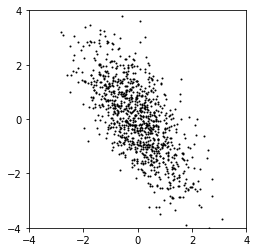

In [15]:
# Gaussian moments
mean_pre = jnp.array([0.0, 0.0])
cov_pre = jnp.array([[1.0, -1.0], [-1, 2.0]])

points = generate_2d_gaussian(mean_pre, cov_pre)
plot_data(points)
savefig("ekf_vs_ukf_source_data")

Next, we define some non-linear transformation to be applied to the points. This is a variation on Figure 5.3(b) of Särkkä.

In [14]:
def non_linear_transform(point):
    x = jnp.sin(point[0] - point[1])
    y = point[1]
    return jnp.array([x, y])

/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


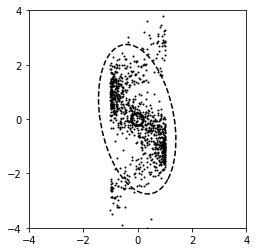

In [15]:
transformed_points = vmap(non_linear_transform)(points)
ax = plot_data(transformed_points)
plot_stats(transformed_points, ax, ls="--", lw=3)
savefig("ekf_vs_ukf_target_data")

We can examine the mean and covariance of the Gaussian random samples, as in Figure 5.4(a) of Särkkä.

/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


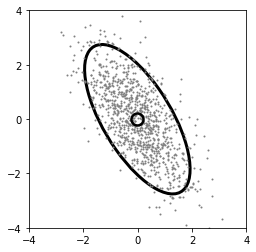

In [16]:
ax = plot_data(points, color="gray")
plot_stats(points, ax, lw=3)
savefig("ekf_vs_ukf_source_linearized")

We compare the EKF approximation to the transformation (solid line) to the true distribution (dashed line), as in Figure 5.4(b) of Särkkä.

/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


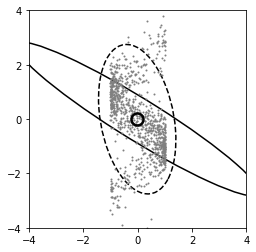

In [17]:
ekf_mean, ekf_cov, _ = EKF().transform(non_linear_transform, mean_pre, cov_pre)

ax = plot_data(transformed_points, color="gray")
plot_stats(transformed_points, ax, ls="--", lw=3)
plot_ellipse(ekf_cov, ekf_mean, ax, n_std=2.0, lw=3)
savefig("ekf_vs_ukf_target_linearized")

Next, we turn our attention to UKF.

In [18]:
# Initialize UKF object with tuned alpha
ukf = UKF(alpha=1.0)

# Compute sigma points pre- and post-transform
sigmas_ukf_pre, sigmas_ukf_post = ukf.sigma_points(non_linear_transform, mean_pre, cov_pre)

# Compute target moments
ukf_mean, ukf_cov, _ = ukf.transform(non_linear_transform, mean_pre, cov_pre)

The sigma points on the source and target are shown as the following (similar to Figures 5.5(a), 5.5(b) of Särkkä).

/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


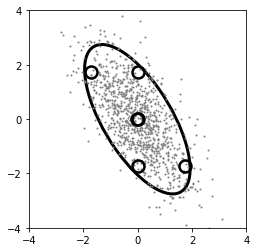

In [19]:
# Sigma points and moments for source distribution
ax = plot_data(points, color="gray")
plot_stats(points, ax, lw=3)
plot_sigmas(ax, sigmas_ukf_pre)
savefig("ekf_vs_ukf_source_sigmas")

/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


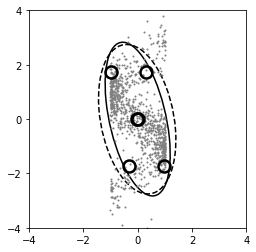

In [20]:
# Sigma points and moments for target distribution
ax = plot_data(transformed_points, color="gray")
plot_stats(transformed_points, ax, ls="--", lw=3)
plot_sigmas(ax, sigmas_ukf_post)
plot_ellipse(ukf_cov, ukf_mean, ax, n_std=2.0, lw=3)
savefig("ekf_vs_ukf_target_sigmas")

Finally, we examine how a fifth order Gauss-Hermite cubature approximates the target distribution.

In [21]:
# Initialize fifth-order GHKF
ghkf = GHKF(order=5)

# Compute sigma points pre- and post-transform
sigmas_ghkf_pre, sigmas_ghkf_post = ghkf.sigma_points(non_linear_transform, mean_pre, cov_pre)

# Compute target moments
ghkf_mean, ghkf_cov, _ = ghkf.transform(non_linear_transform, mean_pre, cov_pre)

/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


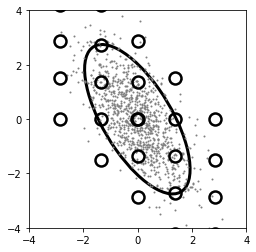

In [22]:
# Sigma points and moments for source distribution
ax = plot_data(points, color="gray")
plot_stats(points, ax, lw=3)
plot_sigmas(ax, sigmas_ghkf_pre)
savefig("ekf_vs_ukf_source_ghkf")

/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


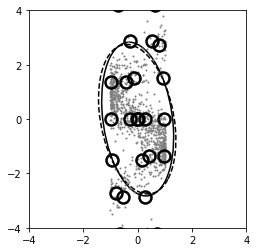

In [23]:
# Sigma points and moments for target distribution
ax = plot_data(transformed_points, color="gray")
plot_stats(transformed_points, ax, ls="--", lw=3)
plot_sigmas(ax, sigmas_ghkf_post)
plot_ellipse(ghkf_cov, ghkf_mean, ax, n_std=2.0, lw=3)
# savefig("ghkf_target_sigmas")
savefig("ekf_vs_ukf_target_ghkf")